In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt
from torchinfo import summary
from going_modular import data_setup, engine
import os
import zipfile
from pathlib import Path
import requests

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

# 1. Get data

In [3]:
def download_data(url: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Download zipped dataset from sourse and unzip to destanation."""

    data_path = Path("data_07/")
    file_path = data_path / destination

    if file_path.is_dir():
        print(f"{file_path} derictory axist")
    else:
        print(f"{file_path} doesn't found, creating directory...")
        file_path.mkdir(parents=True, exist_ok=True)

        target_file = Path(url).name
        with open(data_path/target_file, "wb") as f:
            reqest = requests.get(url)
            f.write(reqest.content)

        with zipfile.ZipFile(data_path/target_file, "r") as zip_ref:
            print(f"Unzipping...")
            zip_ref.extractall(file_path)

        if remove_source:
            os.remove(data_path/target_file)
    return file_path

In [4]:
image_path = download_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

data_07\pizza_steak_sushi derictory axist


WindowsPath('data_07/pizza_steak_sushi')

# 2. Turn Data in to dataloader

In [5]:
train_dir = image_path/"train"
test_dir = image_path/"test"

## Manual transform

In [6]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
manual_transform = transforms.Compose([
    transforms.Resize((224,244)),
    transforms.ToTensor(),
    normalize])

In [7]:
train_dateloader, test_dataloadet, class_names = data_setup.create_dataloader(train_dir=train_dir, test_dir=test_dir, batch_size=32, num_workers=os.cpu_count(), transforms=manual_transform)
train_dateloader, test_dataloadet, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e5074a9bb0>,
 ['pizza', 'steak', 'sushi'])

## Auto transfrom

In [8]:
weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights

EfficientNet_B0_Weights.IMAGENET1K_V1

In [9]:
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)

In [10]:
train_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir=train_dir, test_dir=test_dir, batch_size=32, num_workers=os.cpu_count(), transforms=auto_transforms)
train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e5078285c0>,
 ['pizza', 'steak', 'sushi'])

# 3. Getting a pritrained model, frezz base layers and change classifier head

In [11]:
model_0 = torchvision.models.efficientnet_b0(weights=weights)
model_0

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

In [12]:
for param in model_0.features.parameters():
    param.requires_grad = False

In [13]:
model_0.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=True)
  (1): Linear(in_features=1280, out_features=1000, bias=True)
)

In [14]:
model_0.classifier = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=1280, out_features=len(class_names)))


In [15]:
summary(model_0, 
        input_size=[32, 3, 224, 224], 
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        verbose=0)

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

# 4. Train a singl model and track results 

In [16]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_0.parameters(), lr=0.001)

In [17]:
!pip install tensorboard

In [18]:
# Setup SummaryWriter
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()
writer

In [19]:
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train_step(model: nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: nn.Module,
               optimizer: torch.optim.Optimizer):
    
    train_loss, train_acc = 0, 0
    model.train()

    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item() / len(y_pred)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    return train_loss, train_acc

def test_step(model: nn.Module,
          data_loader: torch.utils.data.DataLoader,
          loss_fn: nn.Module):

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(data_loader):
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
    
            loss = loss_fn(test_pred, y)
            test_loss += loss.item()
            test_pred_labels = test_pred.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item() / len(test_pred_labels))
    
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    
    return test_loss, test_acc

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device):
    # Create empty dictionary for results.
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, 
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn)
        print(f"Eprch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.1f} % | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.1f} % ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        # See SummaryWriter documentation
        writer.add_scalars(main_tag="Loss",
                           tag_scalar_dict={"train_loss": train_loss,
                                            "test_loss": test_loss},
                           global_step=epoch)
        writer.add_scalars(main_tag="Acc",
                          tag_scalar_dict={"train_acc": train_acc,
                                           "test_acc": test_acc},
                          global_step=epoch)
        writer.add_graph(model=model,
                         input_to_model=torch.randn(32, 3, 224, 224).to(device))
    # Close the Writer
    writer.close()
    ### End New ###

    return results

In [20]:
results = train(model=model_0, train_dataloader=test_dataloader, test_dataloader=test_dataloader, optimizer=optimizer, loss_fn=loss_fn)
results

C:\Users\pytho\anaconda3\Lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Eprch: 0 | Train Loss: 1.28 | Train Acc: 0.2 % | Test Loss: 1.22 | Test Acc: 0.2 % 
Eprch: 1 | Train Loss: 1.06 | Train Acc: 0.4 % | Test Loss: 1.03 | Test Acc: 0.5 % 
Eprch: 2 | Train Loss: 0.97 | Train Acc: 0.5 % | Test Loss: 0.92 | Test Acc: 0.5 % 
Eprch: 3 | Train Loss: 0.90 | Train Acc: 0.6 % | Test Loss: 0.87 | Test Acc: 0.6 % 
Eprch: 4 | Train Loss: 0.89 | Train Acc: 0.6 % | Test Loss: 0.85 | Test Acc: 0.6 % 


{'train_loss': [1.2756299177805583,
  1.0598263343175252,
  0.9736692110697428,
  0.9037207365036011,
  0.8911639451980591],
 'train_acc': [0.2178030303030303,
  0.42234848484848486,
  0.5340909090909091,
  0.59375,
  0.5729166666666666],
 'test_loss': [1.2220839659372966,
  1.033116638660431,
  0.9226498206456503,
  0.8740079998970032,
  0.8490184744199117],
 'test_acc': [0.2490530303030303,
  0.4630681818181818,
  0.5435606060606061,
  0.59375,
  0.5729166666666666]}

# 5. View our resuls with TensorBoard

In [21]:
# Restart tensorboard 
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

ERROR: The process "tensorboard.exe" not found.


In [22]:
# %load_ext tensorboard
%reload_ext tensorboard
%tensorboard --logdir runs

# 6. Create a function to prepare a `SummaryWrite()` instance 

In essence, each experiment gets its own logs directory.

For example, say we'd like to track things like:

 - Experiment date/timestamp - when did the experiment take place?
 - Experiment name - is there something we'd like to call the experiment?
 - Model name - what model was used?
 - Extra - should anything else be tracked?

log_dir to be something like:

runs/YYYY-MM-DD/experiment_name/model_name/extra

In [23]:
def create_writer(experiment_name: str,
                  model_name: str,
                  extra: str = None):
    """ Create a torch.utils.tensorboard.SummeryWriter() instance tracking to a specific diractory"""
    import os
    from datetime import datetime

    #Get a timestamp of curent date in reverse order  
    timestamp = datetime.now().strftime("%Y-%m-%d")

    if extra:
        #Create log dir path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
    print(f"[INFO] Created SummaryWriter saving to {log_dir}")

    return SummaryWriter(log_dir=log_dir)

In [24]:
example_writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetB0",
                               extra="5_epochs")
example_writer

[INFO] Created SummaryWriter saving to runs\2025-11-24\data_10_percent\effnetB0\5_epochs


## 6.1 Update `train()` function to include a `writer` parameter

In [25]:
from typing import Dict, List, Tuple

from going_modular.engine import train_step, test_step

def train(model: nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5,
          device = device,
          writer: torch.utils.tensorboard.writer.SummaryWriter = None):
    # Create empty dictionary for results.
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

    for epoch in range(epochs):
        train_loss, train_acc = train_step(model=model,
                                           data_loader=train_dataloader,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model, 
                                        data_loader=test_dataloader,
                                        loss_fn=loss_fn)
        print(f"Eprch: {epoch} | Train Loss: {train_loss:.2f} | Train Acc: {train_acc:.1f} % | Test Loss: {test_loss:.2f} | Test Acc: {test_acc:.1f} % ")

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

        ### New: Experiment tracking ###
        if writer:
            # See SummaryWriter documentation
            writer.add_scalars(main_tag="Loss",
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Acc",
                              tag_scalar_dict={"train_acc": train_acc,
                                               "test_acc": test_acc},
                              global_step=epoch)
            writer.add_graph(model=model,
                             input_to_model=torch.randn(32, 3, 224, 224).to(device))
            # Close the Writer
            writer.close()
            ### End New ###
        else:
            pass

    return results

# 7. Setting up a series of mopdelling experiments

In [26]:
data_10_percent = download_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi.zip",
                                destination="pizza_steak_sushi")

data_20_percent = download_data(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/refs/heads/main/data/pizza_steak_sushi_20_percent.zip",
                                destination="pizza_steak_sushi_20_pecent")

data_07\pizza_steak_sushi derictory axist
data_07\pizza_steak_sushi_20_pecent derictory axist


In [27]:
# Set up test directory
test_dir_10 = data_10_percent/"test"

train_dir_10 = data_10_percent/"train"
train_dir_20 = data_20_percent/"train"

In [28]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

simple_trnasform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize
])

In [29]:
train_10_dataloader, test_datalosder, class_names = data_setup.create_dataloader(train_dir=train_dir_10, 
                                                                                       test_dir=test_dir, 
                                                                                       batch_size=32, 
                                                                                       num_workers=os.cpu_count(), 
                                                                                       transforms=simple_trnasform)

train_10_dataloader, test_datalosder, class_names

(<torch.utils.data.dataloader.DataLoader at 0x1e50bf9b6b0>,
 ['pizza', 'steak', 'sushi'])

In [30]:
train_20_dataloader, test_dataloader, class_names = data_setup.create_dataloader(train_dir=train_dir_20, 
                                                                                       test_dir=test_dir, 
                                                                                       batch_size=32, 
                                                                                       num_workers=os.cpu_count(), 
                                                                                       transforms=simple_trnasform)
train_20_dataloader, test_dataloader, class_names
print(f"Number of batches of size 32 in 10% train_data: {len(train_10_dataloader)}")
print(f"Number of batches of size 32 in 20% train_data: {len(train_20_dataloader)}")
print(f"Number of batches of size 32 in 10% train_data: {len(test_dataloader)}")
print(f"Class_names: {class_names}")

Number of batches of size 32 in 10% train_data: 8
Number of batches of size 32 in 20% train_data: 15
Number of batches of size 32 in 10% train_data: 3
Class_names: ['pizza', 'steak', 'sushi']


In [31]:
def create_sffentb0():
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=len(class_names), bias=True)).to(device)

    # Create model name
    model.name = "effnetb0"
    print(f"[INFO] Created new {model.name}")
    return model

created_model_test = create_sffentb0()

[INFO] Created new effnetb0


In [32]:
summary(model=created_model_test,
        input_size=(32, 3, 224, 224),
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 3]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

In [33]:
# Create a EffentB2 function 
def create_effnetb2():
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    model = torchvision.models.efficientnet_b2(weights=weights).to(device)

    for param in model.features.parameters():
        param.requires_grad = False

    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=len(class_names), bias=True)).to(device)

    # Create model name
    model.name = "effnetb2"
    print(f"[INFO] Created new {model.name}")
    return model

## 7.1 Create experiments and set up training code 

In [34]:
# Create list of epoch
num_epochs = [5, 10]

# Create models list
models = ["effnetb0", "effnetb2"]

# Create a DataLoader dictionary
train_dataloaders = {"data_10_percent": train_10_dataloader,
                     "data_20_percent": train_20_dataloader}

In [35]:
# %%time
# from going_modular.utils import save_model

# # Keep track of experiment number 
# experimernt_num = 0

# # Loop through each DataLoader
# for dataloader_name, train_dataloder in train_dataloaders.items():
#     # Loop through the epochs
#     for epochs in num_epochs:
#         # loop through each model name and create new model instance
#         for model_name in models:
#             experimernt_num += 1
#             print(f"[INFO] Experiment Number: {experimernt_num}")
#             print(f"[INFO] Model: {model_name}")
#             print(f"[INFO] DataLoder: {dataloader_name}")
#             print(f"[INFO] Num Epoch: {epochs}")

#             # Select and create model
#             if model_name == "effnetb0":
#                 model = create_sffentb0()
#             else:
#                 model = create_effnetb2()

#             # Create a Loss and Optimizer
#             loss_fn = nn.CrossEntropyLoss()
#             optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

#             # Train target model with target dataloader and track experiments
#             train(model=model,
#                   train_dataloader=train_dataloder,
#                   test_dataloader=test_dataloader,
#                   optimizer=optimizer,
#                   loss_fn=loss_fn,
#                   epochs=epochs,
#                   device=device,
#                   writer=create_writer(experiment_name=dataloader_name, 
#                                        model_name=model_name,
#                                        extra=f"{epochs}_epochs")
#                  )

#             # Seve the mode to file 
#             save_filepath = f"07_{model_name}_{dataloader_name}_{epochs}_epochs.pth"
#             save_model(model=model,
#                        target_dir="models",
#                        model_name=save_filepath
#                       )
#             print("-"*50 + "\n")

# 8. View experiments in Tensorboard

In [36]:
# Restart tensorboard 
!taskkill /IM "tensorboard.exe" /F
!rmdir /S /Q %temp%\.tensorboard-info

SUCCESS: The process "tensorboard.exe" with PID 27108 has been terminated.


In [37]:
%reload_ext tensorboard
%tensorboard --logdir runs

The best performing model was:

* Model: Effnetb0
* Dataset: Pizza, steak, sushi 20%
* Epochs: 10

2025-11-24\data_20_percent\effnetb0\10_epochs\Acc_test_acc

# 9. Load in the best model and make predictions with it

In [38]:
best_model_path = "models/07_effnetb0_data_20_percent_10_epochs.pth"

best_model = create_sffentb0()

best_model.load_state_dict(torch.load(best_model_path))

[INFO] Created new effnetb0


<All keys matched successfully>

In [39]:
# Check the model size
# Get the model size in bytes then convert it to megabytes
effnetb0_model_size = Path(best_model_path).stat().st_size // (1024*1024)
print(f"EfficientNetB2 feature extractor model size: {effnetb0_model_size} MB")

EfficientNetB2 feature extractor model size: 15 MB


In [40]:
from going_modular.predictions import pred_and_plot_image

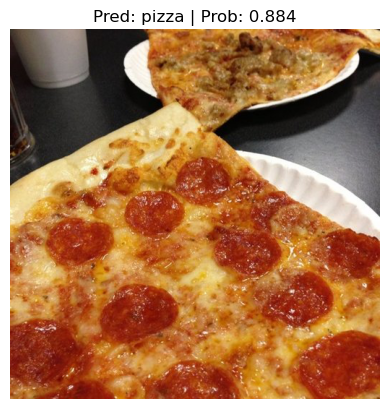

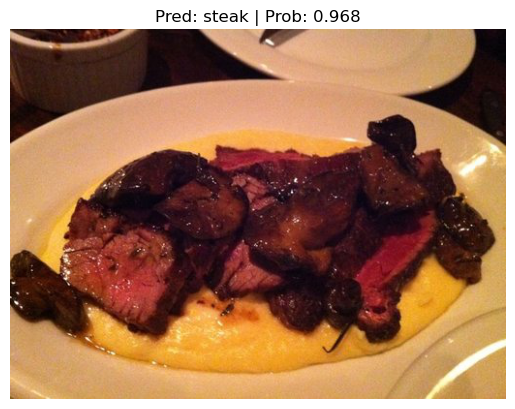

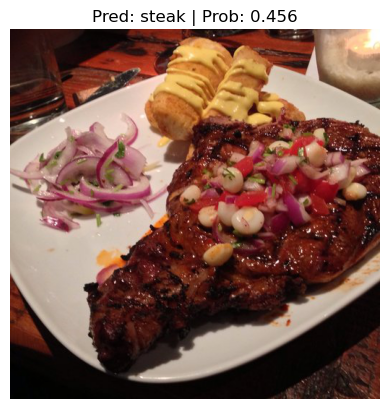

In [44]:
# Get a random list 3 image path names from the test dataset
import random
num_images_to_plot = 3
test_image_path_list = list(Path(data_20_percent / "test").glob("*/*.jpg"))
test_image_path_sample = random.sample(test_image_path_list,
                                       k=num_images_to_plot)

for image in test_image_path_sample:
    pred_and_plot_image(model=best_model, image_path=image, class_names=class_names)

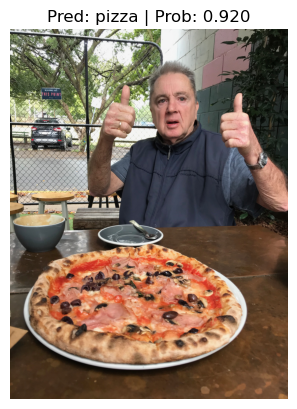

In [45]:
pred_and_plot_image(model=best_model, image_path="data_06/04-pizza-dad.jpeg", class_names=class_names)